In [1]:
%load_ext autoreload
%autoreload 2

import lsp 

import numpy as np
from matplotlib import pyplot as plt

# Combinatorial Auctions Example

In this example we can use the identity $\hat{s}_B = (-1)^{|B|}(\mbox{DSFT}' s)_B$ in order to utilize our existing implementations of fast Fourier transform for set functions [1].

[1] Pueschel, M.; A Discrete Signal Processing Framework for Set Functions; https://acl.inf.ethz.ch/publications/icassp18-setfcts.pdf

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr 

def submatrix_liF(rows, columns):
    prod = cartesian_product(rows, columns)
    intersections = prod[:, :, 0] & prod[:, :, 1]
    subsets = (prod[:, :, 0] & prod[:, :, 1]) == prod[:, :, 1]
    cards = []
    for row in intersections:
        cards.append([lsp.pypopcount(entry) for entry in row])
    cards = np.asarray(cards)
    return (subsets).astype(np.float64)

def lattice_spectrum(s, N):
    popc = lsp.popcount(np.arange(2**N).astype(np.uint32)).astype(np.int32)
    s_hat = lsp.fdsft3(s)
    return s_hat * (-1)**popc

In [3]:
data = np.load('./data/GSVM.npy')
data = data[0]
N = int(np.log2(data.shape[1]))

### For an example valuation function, sort subsets (bundles) by their cardinality and plot the valuation and its spectrum.

In [4]:
popc = lsp.popcount(np.arange(2**N))
s = data[0]
s_hat = lattice_spectrum(s, N)
example = []
example_hat = []
sizes = []
sets = []
for size in range(N+1):
    example += [s[popc == size]]
    example_hat += [s_hat[popc == size]]
    sets += [np.where(popc == size)[0]]
    sizes += (popc == size).sum()*[size]
example = np.concatenate(example)
example_hat = np.concatenate(example_hat)
sets = np.concatenate(sets)
sizes = np.asarray(sizes)

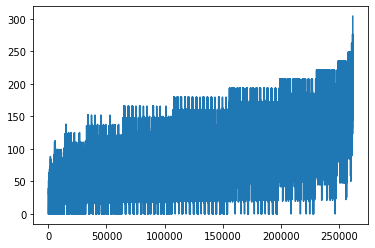

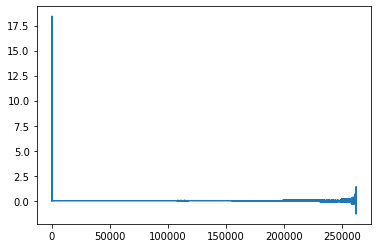

In [5]:
plt.plot(example)
plt.show()
plt.plot(example_hat)
plt.show()

In [6]:
fourier_support = np.where(popc <= 2)[0]
errs = []
for s in data:
    s /= np.linalg.norm(s)
    M = submatrix_liF(fourier_support, fourier_support)
    s_spectrum, _, _, _ = np.linalg.lstsq(M, s[fourier_support], rcond=-1)
    s_hat = np.zeros(2**N)
    s_hat[fourier_support] = s_spectrum
    s_approx = lsp.fidsft3(s_hat * (-1)**popc)
    errs.append(np.linalg.norm(s - s_approx))

In [7]:
print("mean relative of reconstruction error", np.mean(errs))
print("standard deviation of reconstruction error", np.std(errs))

mean relative of reconstruction error 4.314737525604432e-06
standard deviation of reconstruction error 1.7453649107869637e-06
